## Assignment 1: Steady 1D Conduction Heat Transfer in Cylindrical Walls 

### 1-Import Libraries 

In [882]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

### 2-Given conditions with Geometrical Parameters 

In [883]:
T_A = 150;              # the temperature of the fluid inside the cylindrical walls 
T_B = 100;               # The temperature of the fluid outside the cylindrical walls 
alpha_A = 1;           # The heat transfer coefficient of fluid inside the cylindrical walls 
alpha_B = 1;          # The heat transfer coefficient of fluid outside the cylindrical walls 
qv = 0;                 # Internal energy source 
lambd = 1;              # Thermal conductivity for Iron 

H = 1;                  # Height of the cylinder 
Rint = 4;          
Rext = 10; 
N = 15;                 # let us assume the number of control volumes 

#### 4-Vectors for Control Volumes Faces and Nodes

In [884]:
def CV_Faces(Rint,Rext,N):
    e = Rext-Rint; 
    delta_r = e/N;
    r_CV = np.zeros(N+1);              
    for i in range(0,N+1):
        r_CV[i] = Rint + (i)*delta_r;
    return r_CV 
def Nodes(Rint,Rext,N):  
    e = Rext-Rint; 
    r_P = np.zeros(N+2);                         # including initial and final points
    r_P[0] = Rint;
    r_P[N+1] = Rext; 
    r_Faces = CV_Faces(Rint,Rext,N)              # calling the faces function 
    for i in range(1,N+1):
        r_P[i] = (r_Faces[i] + r_Faces[i-1])/2;
    return r_P



#### Volumes of the Control volumes and Areas of Surfaces of Faces


In [885]:
from cmath import pi

def CV_Volumes(H): 
    r_CV = CV_Faces(Rint,Rext,N);
    Volumes = np.zeros(N);
    for i in range(0,N):
        Volumes[i] = (pi*r_CV[i+1]**2*H) - (pi*r_CV[i]**2*H);
    return Volumes 

def Area_Surfaces(Rint,Rext,N,H):
    r_CV = CV_Faces(Rint,Rext,N);
    Area_Surfaces = np.zeros(N+1);
    for i in range(0,N+1):
        Area_Surfaces[i] = 2*pi*r_CV[i]*H;

    return Area_Surfaces 

#### The Discretization Coefficients 

In [886]:
def Discretization_Coefficients(Rint,Rext,N,H,qv):
    surfaces = Area_Surfaces(Rint,Rext,N,H);
    r_faces = CV_Faces(Rint,Rext,N);
    r_P = Nodes(Rint,Rext,N);
    volumes = CV_Volumes(H);
    aE = np.zeros(N+2);
    aW = np.zeros(N+2);
    bP = np.zeros(N+2);
    aP = np.zeros(N+2);
    # Node 1
    aE[0] = lambd/(r_P[1] - r_P[0]); 
    aW[0] = 0;
    aP[0] = aE[0]+alpha_A; 
    bP[0] = alpha_A*T_A;
    # Last Node 
    aE[-1] = 0;
    aW[-1] = lambd/(r_P[-1]-r_P[-2]); 
    aP[-1] = aW[-1] + alpha_B;
    bP[-1] = alpha_B*T_B;
    # All Node in Between 
    for i in range(1,N+1):                      
        aE[i] = (lambd*surfaces[i])/(r_P[i+1]-r_P[i]);
        aW[i] = (lambd*surfaces[i-1])/(r_P[i]-r_P[i-1]);
        bP[i] = qv*volumes[i-1];
        aP[i] = aE[i] + aW[i];
    return aE,aW,bP,aP

In [887]:
[aE,aW,bP,aP] = Discretization_Coefficients(Rint,Rext,N,H,qv)

### Guass Seidel Temperature Solver 

In [893]:
r_P = Nodes(Rint,Rext,N);
T_guess = np.zeros(N+2)
loc_residuals = np.zeros(N+2);
maxIterations = 1e6;
Iterations = 0;
maxResidual = 1e-6;
Residual = maxResidual + 1;
Iterations_graph = np.empty(0);
Error_graph = np.empty(0);
T = np.zeros(N+2);         # Taking initial start as the temperture T_guess 

while (Residual>maxResidual) and (Iterations<maxIterations):
    T[0] = (aE[0]*T[1] + bP[0])/aP[0];
    for i in range(1,N+1):
        T[i] = (aW[i]*T[i-1] + aE[i]*T[i+1] + bP[i])/(aP[i]);

    T[N+1] = (aW[N+1]*T[N] + bP[N+1])/aP[N+1]; 
    Iterations = Iterations + 1; 
    Residual = max(abs(T-T_guess));
    Iterations_graph = np.append(Iterations_graph,Iterations);
    Error_graph = np.append(Error_graph,Residual);
    
    for i in range(0,N+2):
        T_guess[i] = T[i];
    
print("The number of Iterations is",Iterations)


The number of Iterations is 645


In [894]:
 T

array([140.13407578, 138.16089152, 134.5732845 , 131.28464556,
       128.24897976, 125.43014818, 122.79923969, 120.33276396,
       118.01137599, 115.81895493, 113.74192529, 111.76874791,
       109.88953203, 108.09573564, 106.37993087, 104.73561832,
       103.9463486 ])

#### Global Energy Balance 

In [895]:
surface = Area_Surfaces(Rint,Rext,N,H);
global_energy = alpha_A*(T_A - T[0])*surface[0] - alpha_B*(T[N+1]-T_B)*surface[-1] + qv*(Rext**2-Rint**2)*pi*H;
global_energy


0.0013248709874460474

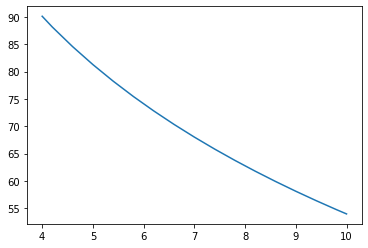

In [868]:
plt.plot(r_P,T)

Text(0, 0.5, 'Residual')

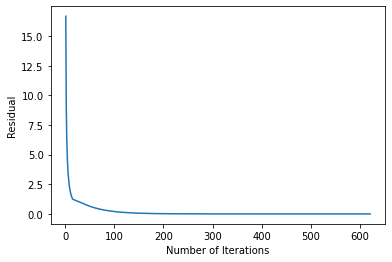

In [869]:
plt.plot(Iterations_graph, Error_graph)
plt.xlabel("Number of Iterations")
plt.ylabel("Residual")

In [870]:
from sympy import* 
from sympy.solvers.solveset import linsolve
(Tw1, Tw2) = symbols('Tw1 Tw2');
C1 = ((Tw1-Tw2)+(qv/(4*lambd)*(Rint**2-Rext**2)))/np.log(Rint/Rext);
equ1 = -(alpha_A*(T_A-Tw1)) + (qv*(Rint/2)) - (lambd/Rint)*C1;
equ2 = -(alpha_B*(Tw2-T_B)) + (qv*(Rext/2)) - (lambd/Rext)*C1;
(a,b), = linsolve([equ1,equ2],(Tw1,Tw2));


In [871]:
a


90.1286492229951

In [872]:

T_analytical = np.empty(0)
for r in r_P:
    T_ana = a + (qv*(Rint**2-r**2))/(4*lambd) + (np.log(r/Rint))*((a-b) + (qv/(4*lambd))*(Rint**2-Rext**2))/(np.log(Rint/Rext));
    T_analytical = np.append(T_analytical,T_ana);
T_analytical

array([90.1286492229951, 88.2021499230587, 84.6100925891522,
       81.3177361483985, 78.2788984155256, 75.4573124170092,
       72.8239766111012, 70.3553351132360, 68.0319942507530,
       65.8377962772527, 63.7591372394697, 61.7844556234776,
       59.9038429098883, 58.1087427432200, 56.3917155690821,
       54.7462523531075, 53.9485403108020], dtype=object)

In [873]:
T

array([90.13407585, 88.1608916 , 84.57328459, 81.28464567, 78.24897987,
       75.4301483 , 72.79923981, 70.33276408, 68.01137611, 65.81895504,
       63.7419254 , 61.768748  , 59.88953212, 58.09573571, 56.37993093,
       54.73561837, 53.94634864])

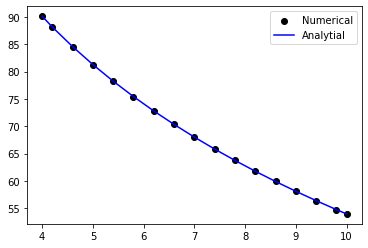

In [874]:
from cProfile import label


plt.scatter(r_P,T,color='black', label = "Numerical")
plt.plot(r_P,T,color='b',label="Analytial")
plt.legend(loc = "upper right")



In [875]:
np.log(10)

2.302585092994046

In [876]:
from sympy import* 
from sympy.solvers.solveset import linsolve
(a, b) = symbols('a b');
equ1 = 3*a-b-3;
equ2 = a+b-1;
solution  = linsolve([equ1,equ2],(a,b))

In [877]:
solution

{(1, 0)}